# Text Clustering on News Dataset

[Dataset on kaggle](https://www.kaggle.com/datasets/narendrageek/reuters21578-multilabel-classification-news)

## Contents
* Data cleaning
* Data preprocessing
* Kernel PCA
* K-Means clustering
* Silhouette score

In [150]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA

Importing news dataset

In [151]:
data = pd.read_csv('reuters21578_news.csv')

In [152]:
data.head(3)

,Unnamed: 0,newID,oldID,title,author,data_split,isTopicsAvailable,document_date,dateline,people,places,orgs,exchanges,topic_body,topics
0,0,1,5544,BAHIA COCOA REVIEW,NaN,TRAIN,YES,26-FEB-1987 15:01:01.79,"SALVADOR, Feb 26 -",[],"['el-salvador', 'usa', 'uruguay']",[],[],Showers continued throughout the week in\nthe ...,['cocoa']
1,1,2,5545,STANDARD OIL <SRD> TO FORM FINANCIAL UNIT,NaN,TRAIN,NO,26-FEB-1987 15:02:20.00,"CLEVELAND, Feb 26 -",[],['usa'],[],[],Standard Oil Co and BP North America\nInc said...,NaN
2,2,3,5546,TEXAS COMMERCE BANCSHARES <TCB> FILES PLAN,NaN,TRAIN,NO,26-FEB-1987 15:03:27.51,"HOUSTON, Feb 26 -",[],['usa'],[],[],Texas Commerce Bancshares Inc's Texas\nCommerc...,NaN


In [153]:
data.shape

(21578, 15)

### Data Cleaning
* Column selection
* Null values
* Duplicate values

In [154]:
data.columns

Index(['Unnamed: 0', 'newID', 'oldID', 'title', 'author', 'data_split',
       'isTopicsAvailable', 'document_date', 'dateline', 'people', 'places',
       'orgs', 'exchanges', 'topic_body', 'topics'],
      dtype='object')

In [155]:
data = data[['topic_body', 'topics']]

Null values

In [156]:
data.isna().sum()

topic_body     2535
topics        10211
dtype: int64

In [157]:
data.dropna(inplace=True)

Duplicate values

In [158]:
data.duplicated().sum()

101

In [159]:
data.drop_duplicates(inplace=True)
data = data.reset_index(drop=True)

Cleaning topics column

In [160]:
data['topics'] = data['topics'].replace('[\',]', '', regex=True)

for i in range(len(data)):
    x = data['topics'][i]
    x = x[1:len(x)-1]
    l = x.split()
    data['topics'][i] = l[0]

In [161]:
data.shape

(10276, 2)

In [162]:
data.head(3)

,topic_body,topics
0,Showers continued throughout the week in\nthe ...,cocoa
1,The U.S. Agriculture Department\nreported the ...,grain
2,Argentine grain board figures show\ncrop regis...,veg-oil


### Data Preprocessing
* Lowercasing and removing newline, tabular spaces, numbers and punctuations
* Stopwords removal
* Lemmatization
* Label encoding
* TF-IDF vectorization 


Lowercasing and removing newline, tabular spaces, numbers and punctuations

In [163]:
data['topic_body']= data['topic_body'].str.lower()

In [164]:
data['topic_body'] = data['topic_body'].replace('[\n\t\'0-9]', '', regex=True)

In [170]:
data['topic_body'] = data['topic_body'].replace('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', ' ', regex=True)

Stopwords removal

In [171]:
stopwords = stopwords.words('english')

In [172]:
def remove_stopwords(text): 
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w.lower() in stopwords]
    filtered_sentence = []
    for w in word_tokens:
        if w not in stopwords:
            filtered_sentence.append(w)
    return " ".join(filtered_sentence)

In [173]:
data['topic_body'] = data['topic_body'].apply(remove_stopwords)

Lemmatization

In [174]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [175]:
def lemmatize(text):
    return " ".join([lemmatizer.lemmatize(w) for w in word_tokenize(text)])

In [176]:
data['topic_body'] = data['topic_body'].apply(lemmatize)

In [177]:
data.head(3)

,topic_body,topics
0,shower continued throughout week inthe bahia c...,cocoa
1,u agriculture departmentreported farmer owned ...,grain
2,argentine grain board figure showcrop registra...,veg-oil


Label encoding

In [178]:
data['topics'].nunique()

81

In [179]:
data['topics'].value_counts()

earn        3749
acq         2182
money-fx     555
grain        488
crude        470
            ... 
wool           1
nzdlr          1
rand           1
fishmeal       1
naphtha        1
Name: topics, Length: 81, dtype: int64

In [180]:
X = data['topic_body']
y = data['topics']

In [181]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [182]:
data['encoded'] = y

In [183]:
data.head(3)

,topic_body,topics,encoded
0,shower continued throughout week inthe bahia c...,cocoa,6
1,u agriculture departmentreported farmer owned ...,grain,23
2,argentine grain board figure showcrop registra...,veg-oil,75


TF-IDF vectorization

In [184]:
tf_idf = TfidfVectorizer()
X = tf_idf.fit_transform(X)

In [185]:
X.shape

(10276, 71130)

In [195]:
y.shape

(10276,)

### Applying Kernel PCA

In [196]:
kpca = KernelPCA(n_components=2, kernel='rbf')
final_transform = kpca.fit_transform(X)

In [197]:
final_transform.shape

(10276, 2)

### Applying Elbow Method

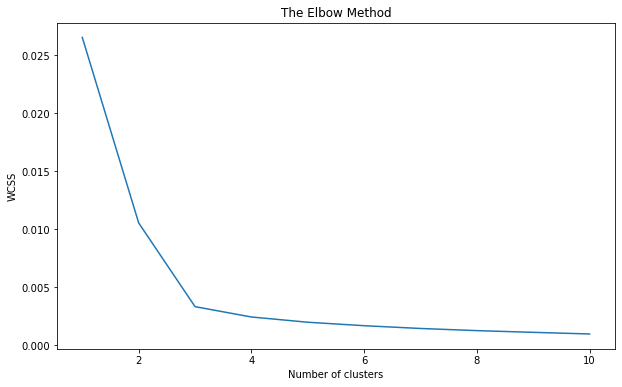

In [198]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=40)
    kmeans.fit(final_transform)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### K-Means Clustering

In [205]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=40)
y_kmeans = kmeans.fit_predict(final_transform)

In [207]:
silhouette_score = metrics.silhouette_score(final_transform, y_kmeans, metric='euclidean')
silhouette_score

0.8134067564936043

### Visualization

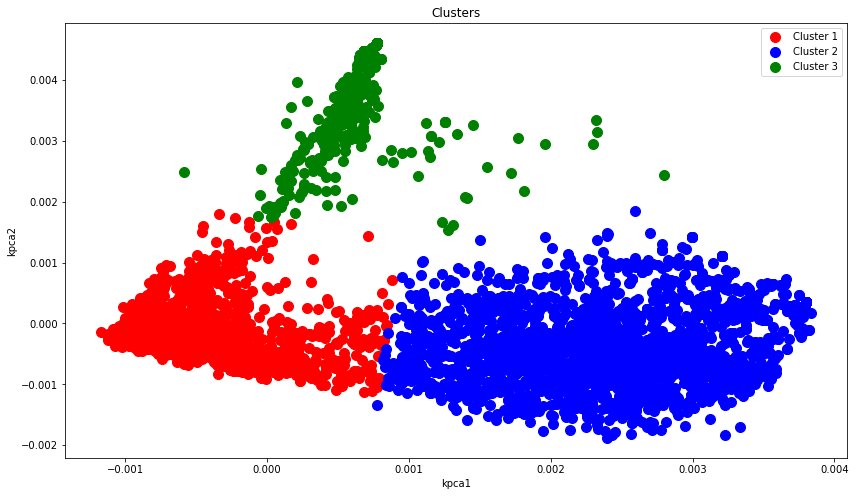

In [208]:
plt.figure(figsize=(14, 8))
plt.scatter(final_transform[y_kmeans == 0, 0], final_transform[y_kmeans == 0, 1], s=100, c='red', label='Cluster 1')
plt.scatter(final_transform[y_kmeans == 1, 0], final_transform[y_kmeans == 1, 1], s=100, c='blue', label='Cluster 2')
plt.scatter(final_transform[y_kmeans == 2, 0], final_transform[y_kmeans == 2, 1], s=100, c='green', label='Cluster 3')
plt.title('Clusters')
plt.xlabel('kpca1')
plt.ylabel('kpca2')
plt.legend()
plt.show()

### Final Analysis

Topic body

In [212]:
final_transform.shape

(10276, 2)

Cluster

In [210]:
y_kmeans.shape

(10276,)

Topics

In [214]:
y.shape

(10276,)

In [217]:
df = pd.DataFrame({'cluster': y_kmeans, 'topics': y})

In [227]:
df[df['cluster'] == 0]['topics'].value_counts()[:10]

0     2181
16    1111
43     555
23     488
14     470
74     422
31     252
64     203
70     145
8      124
Name: topics, dtype: int64

In [231]:
df[df['cluster'] == 1]['topics'].value_counts()

16    2143
0        1
Name: topics, dtype: int64

In [230]:
df[df['cluster'] == 2]['topics'].value_counts()

16    495
Name: topics, dtype: int64